# Notebook to analyze Flight Delay dataset

dataset from kaggle: https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024/data

The source `flight_dataset_2024.csv` contains columns of flight information including factors that were present and may have had to do with flights being delayed. That `.csv` had ~7 million rows. The dataset provider also included `flight_dataset_2024_sample.csv` which contains 10,000 rows. Analysis will be done on this sampled csv. Metadata that denotes what datatypes the columns are was stored in `flight_data_2024_data_dictionary.csv`.

In [18]:
# read the sampled flight delay dataset
flight_df = read.csv('flight_data_2024_sample.csv')
nrow(flight_df)

[1] 10000

In [19]:
# read column metadata
metadata_df = read.csv('flight_data_2024_data_dictionary.csv')
metadata_df

column,dtype,null_pct,example_value
year,Int64,0.00,2024
month,Int64,0.00,1
day_of_month,Int64,0.00,1
day_of_week,Int64,0.00,1
fl_date,datetime64[ns],0.00,2024-01-01 00:00:00
op_unique_carrier,object,0.00,9E
op_carrier_fl_num,float64,0.00,4814.0
origin,object,0.00,JFK
origin_city_name,object,0.00,"New York, NY"
origin_state_nm,object,0.00,New York


In [20]:
# omit any rows with NA's
clean_df = na.omit(flight_df)
nrow(flight_df) - nrow(clean_df)

[1] 164

We see that there were 164 out of the 10,000 rows that had NA's in them. The metadata shown above contains the percentages of NA's in each rows.
We will proceed with the remaining 9836 rows.

Currently, the arrival and departure `delay` columns are measured by how delayed the flight was in minutes where negative values denote if the flight was early. To simplify this, we will create new variables that will signify if a flight was delayed or not by inserting a '1' if the column value is non-zero positive and a '0' for negative and zero values.

In [86]:
# variables to track whether there was a delay or not by seeing whether there is a positive non-zero value 
arr_delay_bin = ifelse(clean_df$arr_delay > 0, 1, 0)

To get a sense of the data, we will choose a set of variables are more closely correlated with departure and arrival delays. A correlation coefficent analysis will be produced.

In [87]:
desired_cols = c(
    "month",
    "day_of_week",
    "crs_arr_time",
    "crs_dep_time",
    "crs_elapsed_time",
    "distance"
)

In [88]:
# perform correlation test
corr_matrix = cor(clean_df[, desired_cols], )
print(round(corr_matrix, 3))

                  month day_of_week crs_arr_time crs_dep_time crs_elapsed_time
month             1.000       0.017        0.000       -0.017           -0.014
day_of_week       0.017       1.000       -0.014       -0.007            0.029
crs_arr_time      0.000      -0.014        1.000        0.706            0.026
crs_dep_time     -0.017      -0.007        0.706        1.000           -0.020
crs_elapsed_time -0.014       0.029        0.026       -0.020            1.000
distance         -0.008       0.028        0.025       -0.015            0.983
                 distance
month              -0.008
day_of_week         0.028
crs_arr_time        0.025
crs_dep_time       -0.015
crs_elapsed_time    0.983
distance            1.000


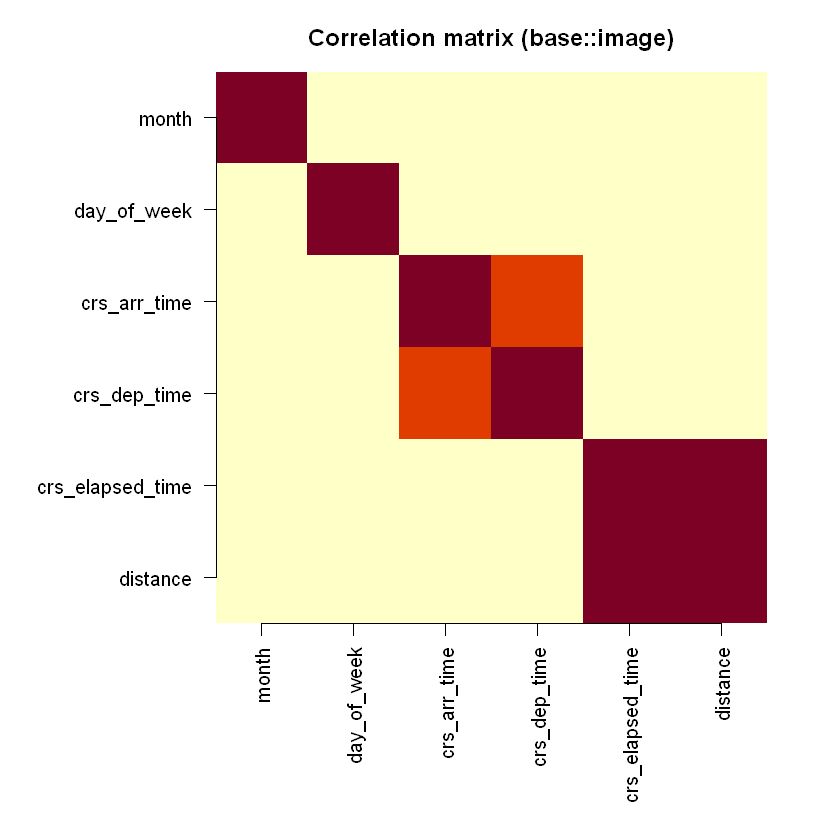

In [89]:
# Create a visualization for correlation
op = par(mar = c(9, 9, 3, 3))
image(1:ncol(corr_matrix), 1:ncol(corr_matrix), t(corr_matrix[ncol(corr_matrix):1, ]),
      axes = FALSE,
      xlab = "", ylab = "", main = "Correlation matrix (base::image)")
axis(1, at = 1:ncol(corr_matrix), labels = colnames(corr_matrix), las = 2)
axis(2, at = 1:ncol(corr_matrix), labels = rev(colnames(corr_matrix)), las = 2)
par(op)

We can see from both the produced matrix and image that there are variables that hare highly correlated with each other. The following variable pair that had both a correlation of over 0.90 and light and dark red on the image was `crs_elapsed_time` and `distance`. For context, the prefix `crs` denotes the scheduled time; for example `crs_arr_time` is the scheduled arrival time whereas `arr_time` is the actual arrival time.

With these variables having high correlation with each other, to reduce multicollinearity, `distance` and will be removed as the `crs_elapsed_time` is calculated by the `distance`.

Because there are two types of delays, arrival and departure, for simplicity's sake, I will perform analysis on arrival only. 

## Arrival delay analysis: Logistic Regression

As a baseline, a logistic regression will be performed using the variable we created, `arr_delay_bin`, as the response, and 
`month`,
`day_of_week`,
`crs_arr_time`,
`crs_dep_time`,
`crs_elapsed_time`,
as the predictors. Using these predictors will allow us to see if there will be a delay in arrival or not. <br> 

Formally: <br>
Null Hypothesis: With Alpha at 0.01, none of the predictors will have a significant relationship with the response `arr_delay_bin`. <br>
Alternative Hypothesis: With Alpha at 0.01, at least one of the predictors will have a significant relationship with the response `arr_delay_bin`

In [90]:
# create logistic regression model
arr_model = glm(arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + month + day_of_week, data=clean_df)
summary(arr_model)


Call:
glm(formula = arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + 
    month + day_of_week, data = clean_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5689  -0.3765  -0.2868   0.5754   0.8289  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.282e-01  2.251e-02   5.697 1.25e-08 ***
crs_arr_time      3.065e-05  1.322e-05   2.319 0.020399 *  
crs_dep_time      1.184e-04  1.388e-05   8.533  < 2e-16 ***
crs_elapsed_time  1.441e-04  6.602e-05   2.183 0.029070 *  
month            -5.265e-03  1.419e-03  -3.711 0.000207 ***
day_of_week       1.177e-02  2.387e-03   4.931 8.30e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.2257274)

    Null deviance: 2276.4  on 9835  degrees of freedom
Residual deviance: 2218.9  on 9830  degrees of freedom
AIC: 13281

Number of Fisher Scoring iterations: 2


We see that `crs_dep_time`, `month`, and `day_of_week` each had p-values that were less than 0.01 leading us to reject the null hypothesis. There was more than one predictor that had a significant linear relationship with `arr_delay_bin`. In other words, those predictors proved to be able to predict whether a flight was delayed.

A ROC curve and AUC analysis can now be produced.

In [92]:
install.packages("pROC")
# library(pROC)

Warning message:
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
  cannot open URL 'https://cran.r-project.org/bin/windows/contrib/3.6/PACKAGES'"Package which is only available in source form, and may need
  compilation of C/C++/Fortran: 'pROC'


  These will not be installed


In [91]:
p_hat = predict(arr_model)

roc_obj = roc(response=arr_delay_bin, predictor=p_hat, quiet=TRUE)
plot(roc_obj, main = "ROC curve")
auc(roc_obj)

ERROR: Error in roc(response = arr_delay_bin, predictor = p_hat, quiet = TRUE): could not find function "roc"
